In [1]:
# https://huggingface.co/am-azadi/EXIST2024_Task2_xlmRoberta_large_3_16

In [2]:
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from statistics import mode
from sklearn import metrics
import matplotlib.pyplot as plt

# xlmRoBERTa

In [3]:
# Load the tokenizer and model
model_name = "am-azadi/EXIST2024_Task2_xlmRoberta_large_3_16"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# use the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the dataset
with open("EXIST2024_dev.json", "r") as file:
    dataset = json.load(file)

config.json:   0%|          | 0.00/991 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

Aggregation method : only the tweets that are sexist, and the label with max number of occurences

In [4]:
# Create a new label that is the labels_task2 with max occurence for each tweet if the tweet is sexist, otherwise "NO"
data = []
for item_id, item_data in dataset.items():
    if item_data["labels_task1"].count("YES") <= 3:
        label = "NO"
    else:
        label = mode([label for label in item_data["labels_task2"] if label != "-"])

    if label == "-" or label == "UNKNOWN":
        label = "NO"
    data += [{"id": item_data["id_EXIST"], "tweet": item_data["tweet"], "label": label}]

print(data[1])
print(len(data))

{'id': '300002', 'tweet': '@anacaotica88 @MordorLivin No me acuerdo de los detalles de GamerGate, pero ella estuvo en el ojo del huracán recibiendo acoso de hombres indignados (y sus medios frikis) y creo que también acosaron a Brianna Wu, q es transfemenino. Seguramente tuvo eso que ver y quiso "cerrar filas".', 'label': 'JUDGEMENTAL'}
1038


Useful functions

In [5]:
# classes = {0: "JUDGEMENTAL", 1: "DIRECT", 2: "REPORTED", 3:"NO"}
classes = {0:"NO", 1:"DIRECT", 2:"REPORTED", 3:"JUDGEMENTAL"}

# Function to preprocess a tweet and predict
def predict_sexism(tweet):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, max_length=128)
    inputs = inputs.to(device) # FASTER COMPUTATION
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    if not predicted_class in [0, 1, 2, 3] :
        predicted_class = -1
    return predicted_class
    # return classes[predicted_class]

# Function to extract actual and predicted
def get_actual_predicted(res) :
    actual = [item["actual"] for item in res]
    predicted = [item["value"] for item in res]
    return actual, predicted

Running on the dataset

In [6]:
result = [
    {
        "test_case": "EXIST2024",
        "id": item["id"],  # Use the id directly from subset_data
        "actual": item["label"],
        "value": classes[predict_sexism(item["tweet"])],
    }
    for item in data
]

In [7]:
result[0]

{'test_case': 'EXIST2024', 'id': '300001', 'actual': 'NO', 'value': 'NO'}

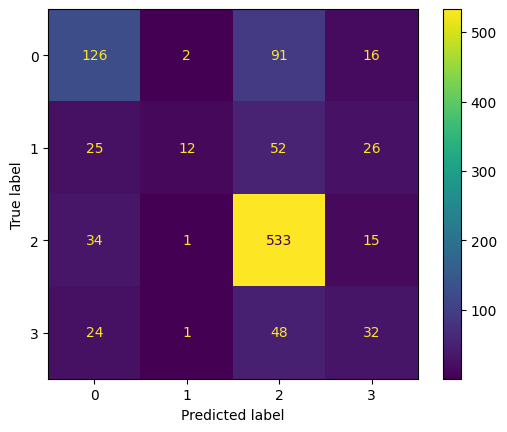

In [9]:
# Confusion matrix

actual, predicted = get_actual_predicted(result)

confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [10]:
# More statistics
print(metrics.classification_report(actual, predicted))

              precision    recall  f1-score   support

      DIRECT       0.60      0.54      0.57       235
 JUDGEMENTAL       0.75      0.10      0.18       115
          NO       0.74      0.91      0.82       583
    REPORTED       0.36      0.30      0.33       105

    accuracy                           0.68      1038
   macro avg       0.61      0.46      0.47      1038
weighted avg       0.67      0.68      0.64      1038



In [11]:
# Save the predictions in a Json file
with open("preds_task2_hard.json", "w") as file:
    json.dump(result, file)